Tamil mBERT

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler

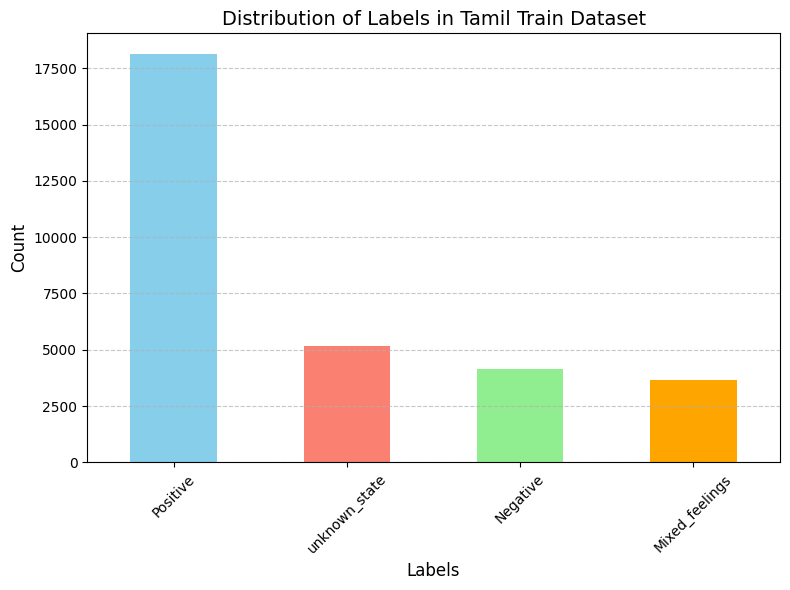

In [ ]:
df = pd.read_csv('/content/Tam-SA-train.csv')

label_counts = df['Label'].value_counts()

plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen', 'orange'])

plt.title('Distribution of Labels in Tamil Train Dataset', fontsize=14)
plt.xlabel('Labels', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


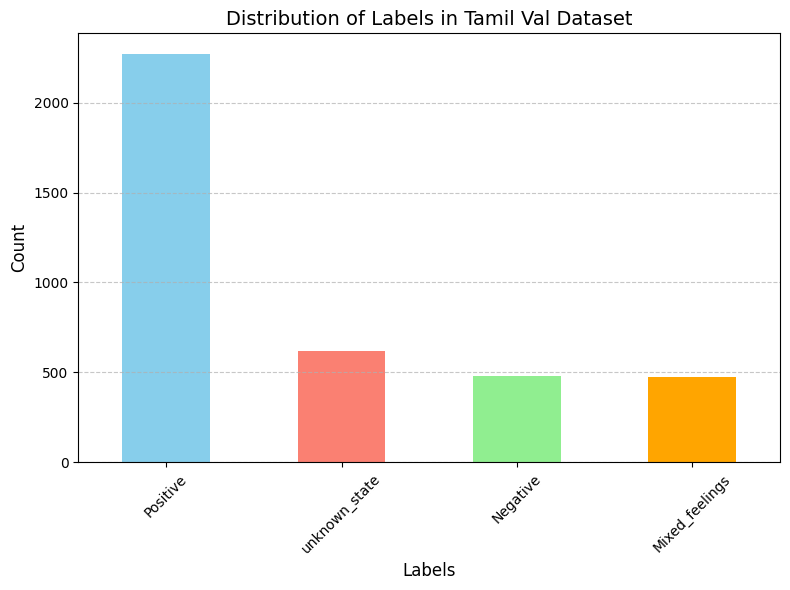

In [ ]:
df = pd.read_csv('/content/Tam-SA-val.csv')

label_counts = df['Label'].value_counts()

plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen', 'orange'])

plt.title('Distribution of Labels in Tamil Val Dataset', fontsize=14)
plt.xlabel('Labels', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [ ]:
df = pd.read_csv('/content/Tam-SA-train.csv')
df['Label'] = df['Label'].map({'Positive': 0, 'Negative': 1, 'unknown_state': 2, 'Mixed_feelings': 3})

# Train-test split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['Text'], df['Label'], test_size=0.2, stratify=df['Label']
)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

class TuluDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer(
            text, max_length=self.max_len, padding='max_length', truncation=True, return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

train_dataset = TuluDataset(train_texts.values, train_labels.values, tokenizer)
val_dataset = TuluDataset(val_texts.values, val_labels.values, tokenizer)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Model
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=4)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
epochs = 1
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader)}")


# Evaluation
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())


accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy * 100:.4f}%")
print(classification_report(true_labels, predictions, target_names=['Positive', 'Negative', 'unknown_state', 'Mixed_feelings']))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1, Loss: 1.1381766691220137
Accuracy: 58.2972%
                precision    recall  f1-score   support

      Positive       0.58      1.00      0.74      3629
      Negative       0.00      0.00      0.00       830
 unknown_state       0.00      0.00      0.00      1033
Mixed_feelings       0.00      0.00      0.00       733

      accuracy                           0.58      6225
     macro avg       0.15      0.25      0.18      6225
  weighted avg       0.34      0.58      0.43      6225



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Oversampling


In [ ]:
# Load and preprocess dataset
df = pd.read_csv('/content/Tam-SA-train.csv')
df['Label'] = df['Label'].map({'Positive': 0, 'Negative': 1, 'unknown_state': 2, 'Mixed_feelings': 3})

# Handle class imbalance using oversampling
ros = RandomOverSampler(random_state=42)
train_texts_resampled, train_labels_resampled = ros.fit_resample(
    pd.DataFrame(df['Text']), df['Label']
)

# Train-test split (after resampling)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts_resampled['Text'], train_labels_resampled, test_size=0.2, stratify=train_labels_resampled
)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

class TamilDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer(
            text, max_length=self.max_len, padding='max_length', truncation=True, return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Create datasets and loaders
train_dataset = TamilDataset(train_texts.values, train_labels.values, tokenizer)
val_dataset = TamilDataset(val_texts.values, val_labels.values, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Model
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=4)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Compute class weights for weighted loss
classes = np.array([0, 1, 2, 3])
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=train_labels_resampled
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Optimizer and loss function
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)

# Training loop (increase epochs)
epochs = 1
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

# Evaluation
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(true_labels, predictions)
print(f"\n\nAccuracy: {accuracy * 100:.4f}%")
print(classification_report(true_labels, predictions, target_names=['Positive', 'Negative', 'unknown_state', 'Mixed_feelings']))

model.save_pretrained('/content/Tamil_model.csv')
tokenizer.save_pretrained('/content/Tamil_model')

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1, Loss: 1.0607


Accuracy: 71.8173%
                precision    recall  f1-score   support

      Positive       0.68      0.64      0.66      3629
      Negative       0.79      0.78      0.79      3629
 unknown_state       0.73      0.73      0.73      3629
Mixed_feelings       0.67      0.73      0.70      3629

      accuracy                           0.72     14516
     macro avg       0.72      0.72      0.72     14516
  weighted avg       0.72      0.72      0.72     14516



Testing

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Load the saved model and tokenizer
model_path = '/content/drive/MyDrive/Tamil_model'
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)


input_sentence = "Ippa than konjam jaathi veri illama konjam ellarum natpa palagi varanga,  athukulla jaathi veriya thundra mathiri oru padam.."

inputs = tokenizer(
    input_sentence,
    max_length=128,
    padding='max_length',
    truncation=True,
    return_tensors="pt"
)

# Move tensors to device
input_ids = inputs['input_ids'].to(device)
attention_mask = inputs['attention_mask'].to(device)

model.eval()
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)
    prediction = torch.argmax(outputs.logits, dim=1).item()

label_map = {0: "Positive", 1: "Negative", 2: "unknown_state", 3: "Mixed_feelings"}
predicted_label = label_map[prediction]

print(f"Predicted Sentiment: {predicted_label}")


Predicted Sentiment: Negative


Tulu mBERT

In [ ]:
df = pd.read_csv('/content/Tulu_SA_train.csv')
df.isna().sum()

,0
Text,0
Label,7


In [ ]:
df = df.dropna()
df.isna().sum()

,0
Text,0
Label,0


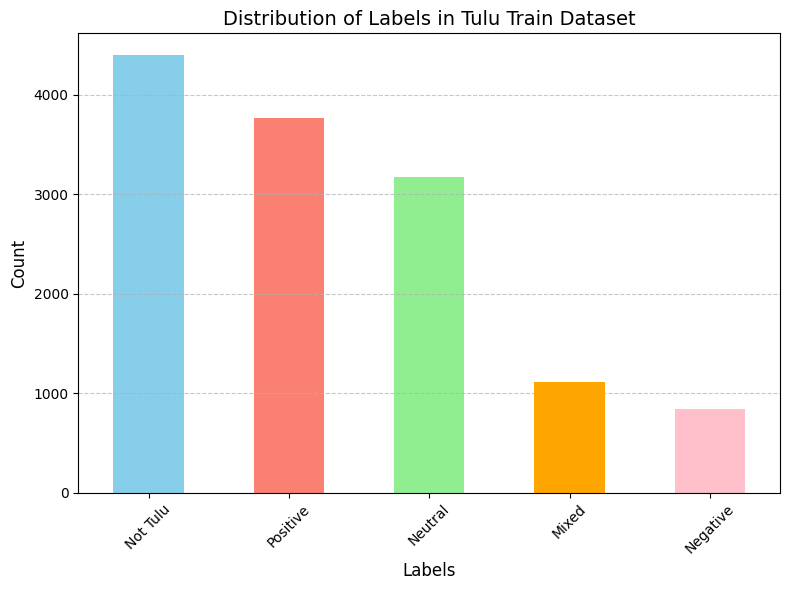

In [ ]:
df = pd.read_csv('/content/Tulu_SA_train.csv')

label_counts = df['Label'].value_counts()

plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen', 'orange', 'pink'])

plt.title('Distribution of Labels in Tulu Train Dataset', fontsize=14)
plt.xlabel('Labels', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


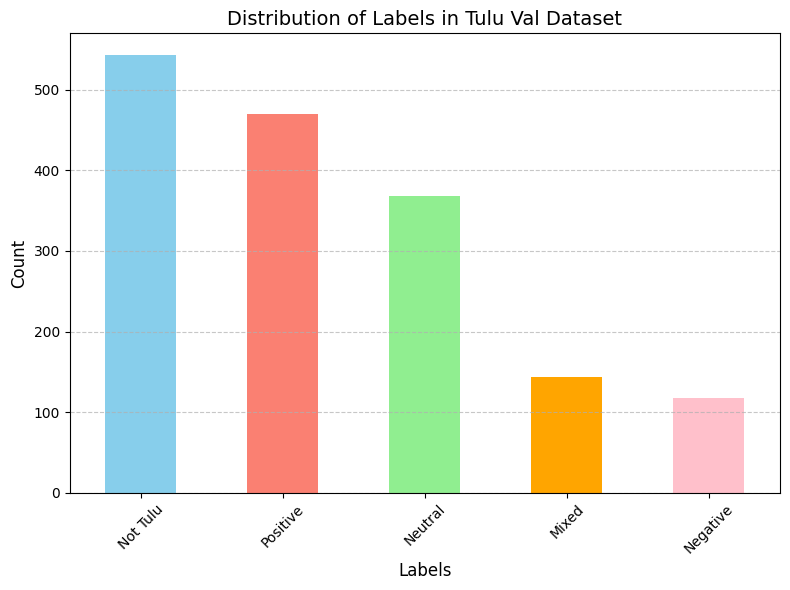

In [ ]:
df = pd.read_csv('/content/Tulu_SA_val.csv')

label_counts = df['Label'].value_counts()

plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen', 'orange', 'pink'])

plt.title('Distribution of Labels in Tulu Val Dataset', fontsize=14)
plt.xlabel('Labels', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from torch.utils.data import Dataset, DataLoader

# Assuming df is already loaded with the label column 'Label' having 5 unique values
df['Label'] = df['Label'].map({'Positive': 0, 'Negative': 1, 'Neutral': 2, 'Mixed': 3, 'Not Tulu': 4})

# Train-test split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['Text'], df['Label'], test_size=0.2, stratify=df['Label']
)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

class TuluDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer(
            text, max_length=self.max_len, padding='max_length', truncation=True, return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Data loaders
train_dataset = TuluDataset(train_texts.values, train_labels.values, tokenizer)
val_dataset = TuluDataset(val_texts.values, val_labels.values, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Model
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=5)  # Change num_labels to 5
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
epochs = 1
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader)}")

# Evaluation
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy * 100:.4f}%")
print(classification_report(true_labels, predictions, target_names=['Positive', 'Negative', 'Neutral', 'Mixed', 'Not Tulu']))

# Save model and tokenizer
model.save_pretrained('/content/Tulu_model')
tokenizer.save_pretrained('/content/Tulu_model')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1, Loss: 1.0746842385682844
Accuracy: 66.9297%
              precision    recall  f1-score   support

    Positive       0.60      0.79      0.68       754
    Negative       0.00      0.00      0.00       169
     Neutral       0.62      0.65      0.63       635
       Mixed       0.29      0.15      0.20       223
    Not Tulu       0.83      0.84      0.83       880

    accuracy                           0.67      2661
   macro avg       0.47      0.49      0.47      2661
weighted avg       0.62      0.67      0.64      2661



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


('/content/Tulu_model/tokenizer_config.json',
 '/content/Tulu_model/special_tokens_map.json',
 '/content/Tulu_model/vocab.txt',
 '/content/Tulu_model/added_tokens.json')

Oversampling

In [ ]:
df['Label'] = df['Label'].map({'Positive': 0, 'Negative': 1, 'Neutral': 2, 'Mixed': 3, 'Not Tulu': 4})

# Handle class imbalance using oversampling
ros = RandomOverSampler(random_state=42)
train_texts_resampled, train_labels_resampled = ros.fit_resample(
    pd.DataFrame(df['Text']), df['Label']
)

# Train-test split (after resampling)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts_resampled['Text'], train_labels_resampled, test_size=0.2, stratify=train_labels_resampled
)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

class TuluDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer(
            text, max_length=self.max_len, padding='max_length', truncation=True, return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Create datasets and loaders
train_dataset = TuluDataset(train_texts.values, train_labels.values, tokenizer)
val_dataset = TuluDataset(val_texts.values, val_labels.values, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Model (set num_labels=5 for the five unique classes)
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=5)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Compute class weights for weighted loss (after resampling)
classes = np.array([0, 1, 2, 3, 4])
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=train_labels_resampled
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Optimizer and loss function
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)

# Training loop (increase epochs)
epochs = 1
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

# Evaluation
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(true_labels, predictions)
print(f"\n\nAccuracy: {accuracy * 100:.4f}%")
print(classification_report(true_labels, predictions, target_names=['Positive', 'Negative', 'Neutral', 'Mixed', 'Not Tulu']))

model.save_pretrained('/content/Tulu_model')
tokenizer.save_pretrained('/content/Tulu_model')

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1, Loss: 1.0618


Accuracy: 71.3182%
              precision    recall  f1-score   support

    Positive       0.52      0.84      0.65       880
    Negative       0.85      0.86      0.86       880
     Neutral       0.72      0.64      0.68       880
       Mixed       0.73      0.63      0.68       880
    Not Tulu       0.93      0.59      0.72       880

    accuracy                           0.71      4400
   macro avg       0.75      0.71      0.72      4400
weighted avg       0.75      0.71      0.72      4400



('/content/Tulu_model/tokenizer_config.json',
 '/content/Tulu_model/special_tokens_map.json',
 '/content/Tulu_model/vocab.txt',
 '/content/Tulu_model/added_tokens.json')

Testing

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Load the saved model and tokenizer
model_path = '/content/Tulu_model'
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)


input_sentence = "à²à²¤à³ à²¨à²¾à²¯à²¿.,. à²®à²¾à²°à³à²°à³†...."

inputs = tokenizer(
    input_sentence,
    max_length=128,
    padding='max_length',
    truncation=True,
    return_tensors="pt"
)

# Move tensors to device
input_ids = inputs['input_ids'].to(device)
attention_mask = inputs['attention_mask'].to(device)

model.eval()
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)
    prediction = torch.argmax(outputs.logits, dim=1).item()

label_map = {0 : 'Positive', 1 : 'Negative', 2 : 'Neutral', 3 : 'Mixed', 4 : 'Not Tulu'}
predicted_label = label_map[prediction]

print(f"Predicted Sentiment: {predicted_label}")


Predicted Sentiment: Negative


Tamil HuggingFace

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import pandas as pd
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils import shuffle

# Load the dataset
df = pd.read_csv('/content/Tam-SA-train.csv')
df = df.dropna()
text_column = "Text"
label_column = "Label"

# Encode labels as integers
label_mapping = {'Positive': 0, 'Negative': 1, 'unknown_state': 2, 'Mixed_feelings': 3}
df[label_column] = df[label_column].map(label_mapping)

# Split the dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df[text_column], df[label_column], test_size=0.2, random_state=42, stratify=df[label_column]
)

# Convert to DataFrame for oversampling
train_df = pd.DataFrame({text_column: train_texts, label_column: train_labels})

# Oversample the training dataset
ros = RandomOverSampler(random_state=42)
train_texts_oversampled, train_labels_oversampled = ros.fit_resample(
    train_df[text_column].values.reshape(-1, 1), train_df[label_column]
)

# Convert back to DataFrame and shuffle
oversampled_df = pd.DataFrame({
    text_column: train_texts_oversampled.flatten(),
    label_column: train_labels_oversampled
}).sample(frac=1, random_state=42)  # Shuffle the oversampled data

# Convert to Hugging Face Dataset
def create_dataset(texts, labels):
    return Dataset.from_dict({"Text": texts, "Label": labels})

train_dataset = create_dataset(
    oversampled_df[text_column].tolist(),
    oversampled_df[label_column].tolist()
)
test_dataset = create_dataset(test_texts.tolist(), test_labels.tolist())

# Load Tamil BERT tokenizer and model
model_name = "l3cube-pune/tamil-bert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=len(label_mapping), from_pt=True
)

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["Text"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Format the dataset for TensorFlow
train_dataset = train_dataset.to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols="Label",
    shuffle=True,
    batch_size=8
)
test_dataset = test_dataset.to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols="Label",
    shuffle=False,
    batch_size=8
)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

# Train the model
history = model.fit(train_dataset, validation_data=test_dataset, epochs=3)

# Predict on the test dataset
predictions = model.predict(test_dataset)
y_pred = tf.argmax(predictions.logits, axis=1).numpy()

# Extract true labels
y_true = []
for batch in test_dataset:
    _, labels = batch
    y_true.extend(labels.numpy())

report = classification_report(y_true, y_pred, target_names=list(label_mapping.keys()))
print("\nClassification Report:")
print(report)



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/58064 [00:00<?, ? examples/s]

Map:   0%|          | 0/6225 [00:00<?, ? examples/s]

Epoch 1/3
7258/7258 [==============================] - 1913s 258ms/step - loss: 1.1107 - accuracy: 0.5238 - val_loss: 1.1716 - val_accuracy: 0.5242
Epoch 2/3
7258/7258 [==============================] - 1868s 257ms/step - loss: 0.6438 - accuracy: 0.7633 - val_loss: 1.3469 - val_accuracy: 0.5563
Epoch 3/3
779/779 [==============================] - 68s 84ms/step

Classification Report:
                precision    recall  f1-score   support

      Positive       0.79      0.70      0.74      3629
      Negative       0.44      0.36      0.39       830
 unknown_state       0.41      0.53      0.46      1033
Mixed_feelings       0.25      0.34      0.29       733

      accuracy                           0.58      6225
     macro avg       0.47      0.48      0.47      6225
  weighted avg       0.62      0.58      0.60      6225



In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader

# Load the test dataset
test_df = pd.read_csv('/content/Tam-SA-test-without-labels.csv')

# Use GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model_name = "l3cube-pune/tamil-bert"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_mapping))

# Move the model to the device
model.to(device)

# Define the dataset class
class TamilTestDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text, max_length=self.max_len, padding='max_length', truncation=True, return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0)
        }

# Create the test dataset and DataLoader
test_dataset = TamilTestDataset(test_df['Text'], tokenizer)
test_loader = DataLoader(test_dataset, batch_size=16)

# Predict the labels
model.eval()
predictions = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        predictions.extend(preds.cpu().numpy())

# Map predictions to original labels
label_map = {0: "Positive", 1: "Negative", 2: "unknown_state", 3: "Mixed_feelings"}
predicted_labels = [label_map[pred] for pred in predictions]

# Add the predicted labels as a new column to the test dataframe
test_df['label'] = predicted_labels

# Save the updated dataframe to a new CSV file
test_df.to_csv('/content/huggingface_tamil_test_with_labels.csv', index=False)

print("Prediction completed and saved to 'huggingface_tamil_test_with_labels.csv'.")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at l3cube-pune/tamil-bert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


OutOfMemoryError: CUDA out of memory. Tried to allocate 578.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 9.06 MiB is free. Process 10564 has 14.74 GiB memory in use. Of the allocated memory 868.43 MiB is allocated by PyTorch, and 31.57 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)